As part of this project, we wanted to see how our model did against traditional image segmentation models. We start by looking at the classic K Means algorithm for a baseline, as the simplist and most well known model for image segmentation. 

In [1]:
#Image segmentation with k means clustering for comparison 
import cv2
import numpy as np
import matplotlib.pyplot as plt

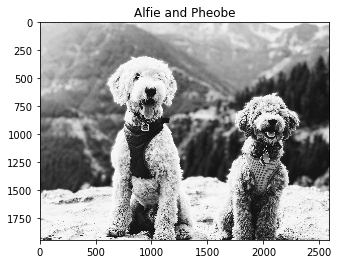

In [56]:
# read the image
image = cv2.imread("doggos.jpg")
# convert to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image, cmap='gray')
plt.title("Alfie and Pheobe")
plt.show()

We gonna use cv2.kmeans() function which takes a 2D array as input, and since our original image is 3D (width, height and depth of 3 RGB values), we need to flatten the height and width into a single vector of pixels (3 RGB values):

In [57]:
# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)
print(pixel_values.shape)
#Aweseome, so we have matrix of how ever many pixels are in the image and 3 columns one for each dimension
# and that's exactly what we wanted. 

(5038848, 3)


In [58]:
# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

In [59]:

# number of clusters (K)
k = 4
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

labels array is the cluster label for each pixel which can take on the values of  0, 1 2, or 3 (since k = 4), centers refers to the center points (each centroid's value).

cv2.KMEANS_RANDOM_CENTERS just indicates OpenCV to randomly assign the values of the clusters initially.

If you look back at the code, we didn't mention that we converted the flattened image pixel values to floats, we did that because cv2.kmeans() expects that, let's convert them back to 8-bit pixel values:

In [60]:
# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

In [61]:
#resegmenting 

# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

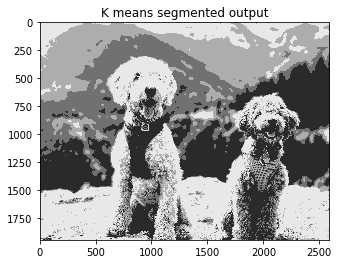

In [62]:
# reshape back to the original image dimension
segmented_image = segmented_image.reshape(image.shape)
# show the image
plt.imshow(segmented_image)
plt.title("K means segmented output")
plt.show()

Now we will look at the image segmentation from the Scikit Library. This approach is a combination of supervized and unsupervised algorithms

In [52]:
#importing 
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
from skimage.color import rgb2gray
from scipy import ndimage

We also wanted to do another supervized comparison, because our model is more graphical, so it's not totally unsupervized, although there are some unsupervized aspects, so what we wanted to do was utilized scikit learns image library to divide the region into two regions, the object(s) and the background. With the dogs picture, this is pretty obvious to a human which is which, the key is teaching a computer to do this. To do so, we define a signle threashold value, this is known as the global threshold. 

If we have multiple objects along with the background, we must define multiple thresholds. THese thresholds are collectively known as the local thresholds. 

This is considered supervized learning because we are deciding the threshold values. 

This histogram shows the distribution of the darkness of the pixels, it shows this image has mostly dark pixels, it will be interesting to see if this plays a roll in how the segmentor does 

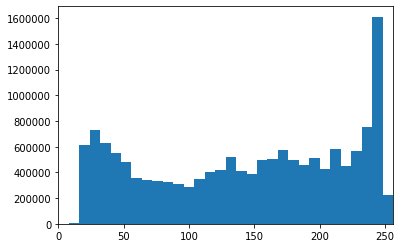

In [65]:
fig, ax = plt.subplots(1, 1)
ax.hist(image.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256);

Because this is the supervized portion of the comparison, we will see how the number of pixels affects the recognition 

In [66]:
print(np.percentile(image.ravel(), 25))
print(np.mean(image.ravel()))
print((np.median(image.ravel())))
print(np.percentile(image.ravel(), 75))

73.0
143.93217279028858
153.0
213.0


In [128]:
#this gets rid of the last dimention
image = plt.imread("doggos.jpg")
#image = plt.imread('1.jpeg')
gray = rgb2gray(image)
gray.shape

(192, 263)

The height and width of the image are shown above, we ill take the average of the pixel values and use that as a threshold, if the pixel is more than our threshold we can say it belons to the dogs, else it is the background. 

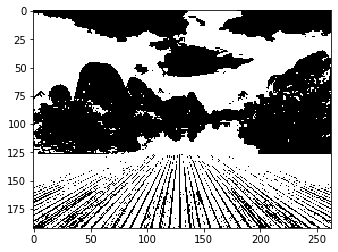

In [129]:
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 1
        #print(i)
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

###### note to self this takes a long time to run, see if you can find a way to speed up tomorrow: 

ok so the black region, represents the background and the whiter / brighter regions are the foreground / dogs, but notice that this does not do a very good job, so we want to be able to define multiple thresholds because there are two dogs 

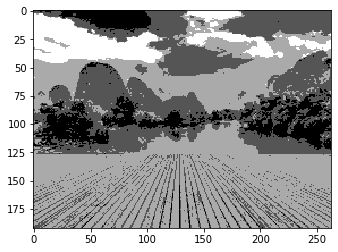

In [130]:

gray = rgb2gray(image)
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 3
    elif gray_r[i] > 0.5:
        gray_r[i] = 2
    elif gray_r[i] > 0.25:
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

As you can see, the segmentation is significantly better when we have more local thresholds instead of global thresholds


we will try one more supervized learning model, this time using supervized segmentation We want to see how active conture segmentation, commonly refered to as snakes, will do in comparison with our graphical approach. 

Active conture segmentation is initialized using a user defined contour or line around the area of interest and this contour then lowly contracts and is attracted or repelled by light and edges. for example, we can draw circles around the dogs 

In [131]:
image = cv2.imread("doggos.jpg")

In [173]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

def circle_points(resolution, center1, center2, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c1 = center1[1] + radius*np.cos(radians)#polar co-ordinates
    r1 = center1[0] + radius*np.sin(radians)
    c2 = center2[1] + radius*np.cos(radians)#polar co-ordinates
    r2 = center2[0] + radius*np.sin(radians)
    #print(np.array([c2, r2]).T)
    return np.array([c1, r1]).T
    #print(np.array([c1, r1]).T)
    return np.array([c2, r2]).T


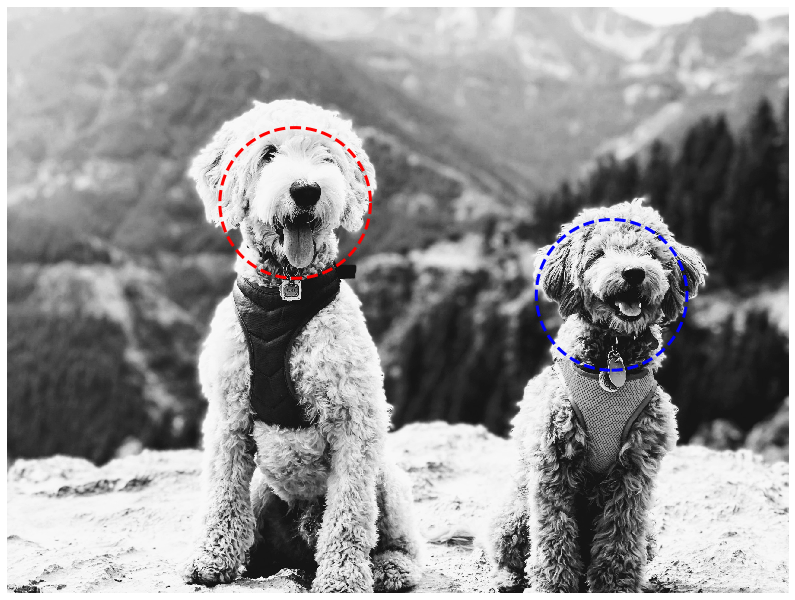

In [191]:

points = circle_points(300, [650, 955], [600, 1500], 250)[:-1]
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(points[:, 1]+1355, points[:, 0], '--b', lw=3)

C:\Users\13855\Anaconda_Re_do\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  """Entry point for launching an IPython kernel.


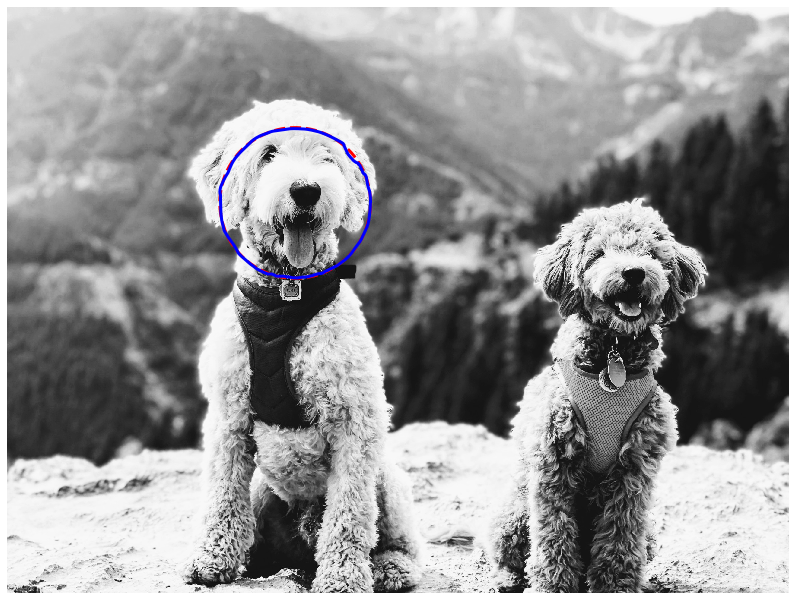

In [192]:
snake = seg.active_contour(image, points)
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);